Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	train's rmse: 31582.4	eval's rmse: 72081.5
MAE: 58504.3989, RMSE: 72081.4667, R2: -0.4303


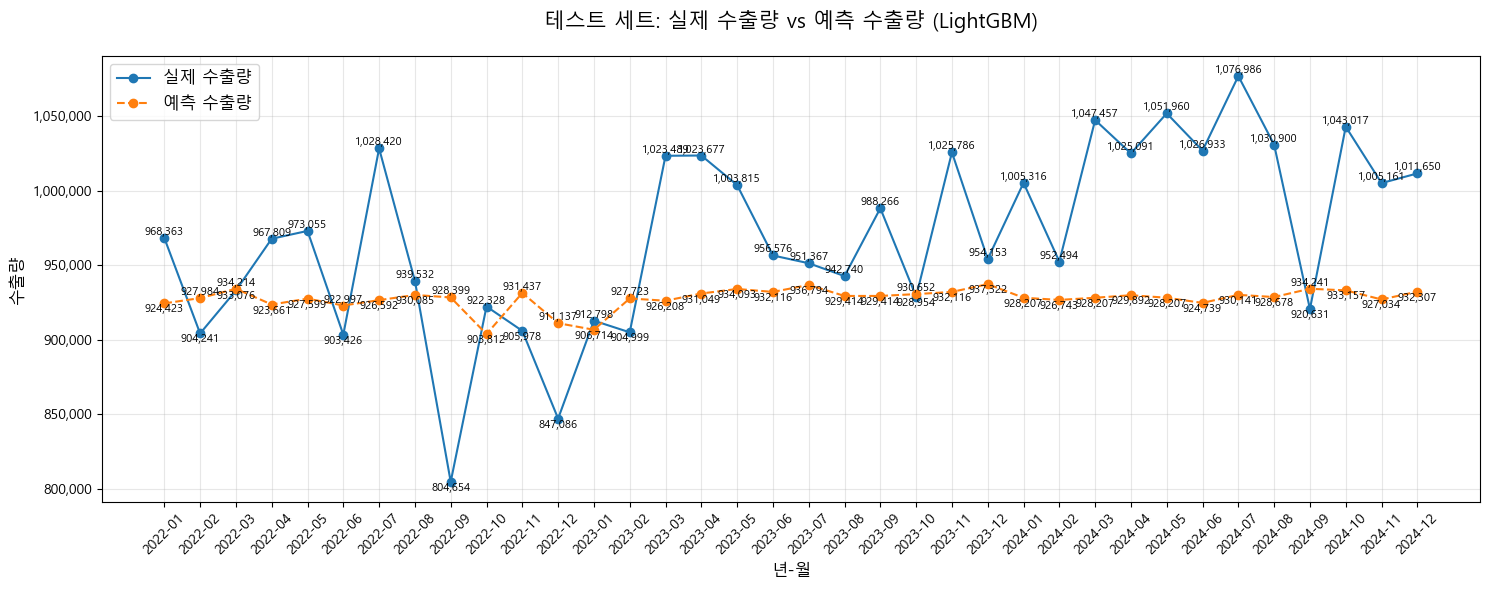


실제값과 예측값 비교 (LightGBM):
             실제 수출량  예측 수출량
date                       
2022-01-01   968363  924423
2022-02-01   904241  927984
2022-03-01   933076  934214
2022-04-01   967809  923661
2022-05-01   973055  927599
2022-06-01   903426  922997
2022-07-01  1028420  926592
2022-08-01   939532  930085
2022-09-01   804654  928399
2022-10-01   922328  903812
2022-11-01   905978  931437
2022-12-01   847086  911137
2023-01-01   912798  906714
2023-02-01   904999  927723
2023-03-01  1023489  926208
2023-04-01  1023677  931049
2023-05-01  1003815  934093
2023-06-01   956576  932116
2023-07-01   951367  936794
2023-08-01   942740  929414
2023-09-01   988266  929414
2023-10-01   928954  930652
2023-11-01  1025786  932116
2023-12-01   954153  937322
2024-01-01  1005316  928207
2024-02-01   952494  926743
2024-03-01  1047457  928207
2024-04-01  1025091  929892
2024-05-01  1051960  928207
2024-06-01  1026933  924739
2024-07-01  1076986  930141
2024-08-01  1030900  928678
2024-09-01   920631  93

In [6]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('data_integ_1.csv', parse_dates=['date'])  # 데이터 통합본 넣기 // 감성지수 데이터도 포함
df.set_index('date', inplace=True)

# Lag 및 파생변수 생성
# 이전 수출량 데이터를 반영해 시계열의 연속성과 패턴을 학습하도록 lag 및 파생 변수 생성
df['lag_1'] = df['export'].shift(1) # 한 달 전 수출량
df['lag_2'] = df['export'].shift(2) # 두 달 전 수출량
df['rolling_3'] = df['export'].rolling(window=3).mean().shift(1) # 이전 3개월간 수출량 평균 (직전 월까지)
df['diff_1'] = df['export'].diff(1).shift(1) # 직전 월 대비 수출량 차이 (변동성 반영)

# 타겟 변수와 피쳐 분리
X = df.drop(columns=['export'])
y = df['export']

# 학습/테스트 데이터 분할 (80:20) (시계열 순서 유지)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# LightGBM 데이터셋 변환
dtrain = lgb.Dataset(data=X_train, label=y_train)
dtest = lgb.Dataset(data=X_test, label=y_test)

# 모델 파라미터 설정
params = {
    'max_depth': 3,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate' : 0.1,
    'verbose' : -1
}
num_rounds = 300

# early_stopping을 위한 callback 설정
callbacks = [lgb.early_stopping(stopping_rounds=30)]

# LightGBM 모델 학습
model = lgb.train(params, dtrain, num_boost_round=num_rounds,
                  valid_sets=[dtrain, dtest],
                  valid_names=['train', 'eval'], # 각각의 데이터셋 이름 지정
                  callbacks=callbacks)  # early stopping 설정

# 예측 수행
preds = model.predict(X_test, num_iteration=model.best_iteration)

# 모델 성능 평가
def get_reg_eval(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

get_reg_eval(y_test, preds)

# ---------------------- 여기서부터는 시각화 코드 ----------------------------
# 예측 결과와 실제 값을 포함한 DataFrame 생성 
results_df = pd.DataFrame({
    '실제 수출량': y_test,
    '예측 수출량': preds
})

# 소수점 반올림 및 정수형 변환
results_df = results_df.round(0).astype(int)

# x축 눈금용 날짜 리스트 생성
dates = results_df.index.strftime('%Y-%m')

# 실제값과 예측값 시각화
plt.figure(figsize=(15, 6))

plt.plot(range(len(dates)), results_df['실제 수출량'], 
         marker='o', linestyle='-', label='실제 수출량', color='#1f77b4')
plt.plot(range(len(dates)), results_df['예측 수출량'], 
         marker='o', linestyle='--', label='예측 수출량', color='#ff7f0e')

# 실제값과 예측값 텍스트 표시 (겹치지 않게)
for i in range(len(dates)):
    real_val = results_df['실제 수출량'].iloc[i]
    pred_val = results_df['예측 수출량'].iloc[i]
    
    if real_val >= pred_val:
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)
    else:
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)

# 그래프 스타일링
plt.title('테스트 세트: 실제 수출량 vs 예측 수출량 (LightGBM)', fontsize=15, pad=20)
plt.xlabel('년-월', fontsize=12)
plt.ylabel('수출량', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)

# x축 설정
plt.xticks(range(len(dates)), dates, rotation=45)

# y축 포맷팅 (천 단위 쉼표)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.tight_layout()
plt.show()

# 결과 출력 (선택 사항)
print("\n실제값과 예측값 비교 (LightGBM):")
print(results_df.to_string(float_format=lambda x: '{:,.0f}'.format(x)))


# 피처 중요도 시각화
# xgb.plot_importance(model, importance_type='weight', height=0.5)
# plt.title('XGBoost Feature Importance')
# plt.tight_layout()
# plt.show()

In [4]:
X.corr()

,gdp_growth,korea_lead,brent_price,exchange_rate,gold_price,gas_price,usa_lead,china_lead,lag_1,lag_2,rolling_3,diff_1
gdp_growth,1.000000,0.525679,0.224595,-0.278481,-0.424329,0.427492,0.522664,0.331913,-0.101640,-0.119403,-0.106745,0.044988
korea_lead,0.525679,1.000000,-0.355594,-0.157058,-0.184590,0.131714,0.363756,0.353890,-0.029674,-0.044595,-0.030083,0.035909
brent_price,0.224595,-0.355594,1.000000,-0.106364,0.225704,0.537408,0.367081,0.188849,-0.200655,-0.215390,-0.261507,0.012492
exchange_rate,-0.278481,-0.157058,-0.106364,1.000000,0.637369,-0.080890,-0.400608,-0.240002,0.079990,0.122457,0.130363,-0.041821
gold_price,-0.424329,-0.184590,0.225704,0.637369,1.000000,-0.060000,-0.190983,-0.081988,0.023863,0.021177,0.003204,-0.011860
gas_price,0.427492,0.131714,0.537408,-0.080890,-0.060000,1.000000,0.361374,0.193201,-0.113878,-0.122069,-0.144593,0.020773
usa_lead,0.522664,0.363756,0.367081,-0.400608,-0.190983,0.361374,1.000000,0.453763,0.067015,0.019042,0.037098,0.043464
china_lead,0.331913,0.353890,0.188849,-0.240002,-0.081988,0.193201,0.453763,1.000000,-0.149755,-0.163827,-0.204029,0.024461
lag_1,-0.101640,-0.029674,-0.200655,0.079990,0.023863,-0.113878,0.067015,-0.149755,1.000000,0.467662,0.790095,0.508680
lag_2,-0.119403,-0.044595,-0.215390,0.122457,0.021177,-0.122069,0.019042,-0.163827,0.467662,1.000000,0.803305,-0.523115
